# PubMedQA Benchmark (llama-server 기반)
Llama 3.1 / EXAONE 7.8B 각각에 대해
- Prompt only
- +RAG (FAISS dense retrieval)
- +Advanced RAG (TopN → CrossEncoder rerank → TopK)

이 노트북은 `llama-server`를 **한 번 띄워놓고 HTTP로 호출**하여, 매 질문마다 모델을 재로딩하지 않도록 구성했습니다.


## 0. 설정

In [2]:

SEED = 42
EVAL_N = 200          # 먼저 50~200으로 파이프라인 확인 후 늘리세요
TOPK = 5
ADV_TOPN = 50

MAX_NEW_TOKENS = 32   # PubMedQA yes/no/maybe면 16~32 권장
TEMPERATURE = 0.0

PORT_LLAMA = 8080
PORT_EXAONE = 8081


## 1. 패키지 설치

In [3]:

!pip -q install datasets pandas numpy scikit-learn tqdm faiss-cpu sentence-transformers matplotlib requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 102.0 MB/s eta 0:00:00


## 2. llama.cpp 빌드 (CMake)

In [4]:

!apt-get -qq update
!apt-get -qq install -y git cmake build-essential

!rm -rf /content/llama.cpp
!git clone -q https://github.com/ggml-org/llama.cpp /content/llama.cpp

!cd /content/llama.cpp && cmake -B build
!cd /content/llama.cpp && cmake --build build -j --target llama-server llama-cli
!ls -lh /content/llama.cpp/build/bin | head


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMAKE_BUILD_TYPE=Release
-- Found Git: /usr/bin/git (found version "2.34.1")
-- The ASM compiler identification is GNU
-- Found assembler: /usr/bin/cc
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE
-- Warning: ccache not found - consi

## 3. GGUF 모델 다운로드
403/404가 나면 repo/file만 바꿔서 사용하세요.

In [5]:

import os

# 필요하면 여기만 바꾸세요
LLAMA_GGUF_REPO = "bartowski/Meta-Llama-3.1-8B-Instruct-GGUF"
LLAMA_GGUF_FILE = "Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf"

EXAONE_GGUF_REPO = "bartowski/EXAONE-3.5-7.8B-Instruct-GGUF"
EXAONE_GGUF_FILE = "EXAONE-3.5-7.8B-Instruct-Q4_K_M.gguf"

LLAMA_MODEL_PATH = "/content/llama31.gguf"
EXAONE_MODEL_PATH = "/content/exaone78.gguf"

def wget(url, out_path):
    if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
        print("✅ already exists:", out_path)
        return
    print("Downloading:", url)
    !wget -O {out_path} "{url}"

llama_url = f"https://huggingface.co/{LLAMA_GGUF_REPO}/resolve/main/{LLAMA_GGUF_FILE}"
exaone_url = f"https://huggingface.co/{EXAONE_GGUF_REPO}/resolve/main/{EXAONE_GGUF_FILE}"

wget(llama_url, LLAMA_MODEL_PATH)
wget(exaone_url, EXAONE_MODEL_PATH)

!ls -lh /content/*.gguf


Downloading: https://huggingface.co/bartowski/Meta-Llama-3.1-8B-Instruct-GGUF/resolve/main/Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf
--2026-02-10 00:09:18--  https://huggingface.co/bartowski/Meta-Llama-3.1-8B-Instruct-GGUF/resolve/main/Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.118, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/669fce02988201fd4f9ceddc/854506123b68372492b8a99bb3a999594672b394791cf1153f8da5ffb5f1c59a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf%3B+filename%3D%22Meta-Llama-3.1-8B-Instruct-Q4_K_M.gguf%22%3B&Expires=1770685758&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzcwNjg1NzU4fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjY5ZmNlMDI5ODgy

## 4. PubMedQA 로드 + 샘플링

In [6]:

from datasets import load_dataset
import random

random.seed(SEED)

ds = load_dataset("qiaojin/PubMedQA", "pqa_labeled")
data = ds["train"]

idxs = list(range(len(data)))
random.shuffle(idxs)
idxs = idxs[:EVAL_N]

eval_items = []
for i in idxs:
    q = data[i]["question"]
    ctx_list = data[i]["context"]["contexts"] if isinstance(data[i]["context"], dict) else data[i]["context"]
    ctx_text = " ".join(ctx_list) if isinstance(ctx_list, list) else str(ctx_list)
    label = data[i]["final_decision"].lower().strip()
    eval_items.append({"question": q, "context": ctx_text, "label": label})

eval_items[0]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'question': 'Does open access endoscopy close the door to an adequately informed patient?',
 'context': 'The use of open access endoscopy is increasing. Its effect on the adequacy of patient informed consent, procedure acceptance and the impact on subsequent communication/transfer of procedure results to the patient have not been evaluated. The aim of our study was to compare the extent of preknowledge of procedures and test explanation, patient medical complexity, information transfer and overall patient satisfaction between a patient group referred for outpatient open access endoscopy versus a patient group from a gastrointestinal (GI) subspecialty clinic. Information was obtained from all patients presenting for outpatient upper and lower endoscopy by using a 1-page questionnaire. Patients from the two groups who had an outpatient upper/lower endoscopic procedure were contacted by phone after the procedure to obtain information with a standardized questionnaire. The open access pat

## 5. RAG 인덱스 구축 (Dense + FAISS)

In [7]:

import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

docs = [it["context"] for it in eval_items]

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

doc_emb = embed_model.encode(docs, normalize_embeddings=True, show_progress_bar=True)
doc_emb = np.asarray(doc_emb, dtype=np.float32)

index = faiss.IndexFlatIP(doc_emb.shape[1])
index.add(doc_emb)

def retrieve_topk(query: str, k=5):
    q_emb = embed_model.encode([query], normalize_embeddings=True)
    D, I = index.search(np.asarray(q_emb, dtype=np.float32), k)
    return [docs[i] for i in I[0]]


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

## 6. Advanced RAG: TopN → Rerank → TopK

In [8]:

from sentence_transformers import CrossEncoder

reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def retrieve_rerank(query: str, topn=50, topk=5):
    cand = retrieve_topk(query, k=topn)
    pairs = [(query, c) for c in cand]
    scores = reranker.predict(pairs)
    ranked = [c for _, c in sorted(zip(scores, cand), key=lambda x: x[0], reverse=True)]
    return ranked[:topk]


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

## 7. 프롬프트/파서

In [9]:

LABELS = ["yes", "no", "maybe"]

def parse_answer(text: str) -> str:
    t = (text or "").lower()
    positions = [(l, t.find(l)) for l in LABELS if l in t]
    if not positions:
        return "maybe"
    return sorted(positions, key=lambda x: x[1])[0][0]

def prompt_only(q):
    return f"""You are a biomedical expert.
Answer strictly with one word: yes, no, or maybe.

Question: {q}
Answer:"""

def prompt_rag(q, evidences):
    ctx = "\n".join([f"- {e[:600]}" for e in evidences])
    return f"""You are a biomedical expert.
Use the evidence to answer.
Answer strictly with one word: yes, no, or maybe.

Evidence:
{ctx}

Question: {q}
Answer:"""


## 8. llama-server 실행/종료 + HTTP 호출

In [10]:
!cd /content/llama.cpp && cmake -B build
!cd /content/llama.cpp && cmake --build build -j --target llama-server
!cd /content/llama.cpp && find build -type f -name "llama-server" -print


CMAKE_BUILD_TYPE=Release
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- GGML_SYSTEM_ARCH: x86
-- Including CPU backend
-- x86 detected
-- Adding CPU backend variant ggml-cpu: -march=native 
-- ggml version: 0.9.5
-- ggml commit:  98e57ca42
-- OpenSSL found: 3.0.2
-- Generating embedded license file for target: common
-- Configuring done (0.3s)
-- Generating done (0.2s)
-- Build files have been written to: /content/llama.cpp/build
[  0%] Built target build_info
[  0%] Built target cpp-httplib
[  3%] Built target ggml-base
[ 11%] Built target ggml-cpu
[ 12%] Built target ggml
[ 72%] Built target llama
[ 81%] Built target mtmd
[ 83%] Building CXX object common/CMakeFiles/common.dir/__/license.cpp.o
[ 83%] Linking CXX static library libcommon.a
[ 94%] Built target common
[ 96%] Built target server-context
[ 98%] Linking CXX executable ../../bin/llama-server
[100%] Built target ll

In [11]:

import subprocess, time, requests, os

LLAMA_SERVER_BIN = "/content/llama.cpp/build/bin/llama-server"
assert os.path.exists(LLAMA_SERVER_BIN), f"llama-server not found at {LLAMA_SERVER_BIN}"

def wait_server_ready(port, timeout=180):
    t0 = time.time()
    while time.time() - t0 < timeout:
        try:
            r = requests.get(f"http://127.0.0.1:{port}/health", timeout=2)
            if r.status_code == 200:
                return True
        except Exception:
            pass
        time.sleep(0.5)
    return False

def start_llama_server(model_path: str, port: int, ctx_size=2048):
    cmd = [
        LLAMA_SERVER_BIN,
        "-m", model_path,
        "--host", "127.0.0.1",
        "--port", str(port),
        "--ctx-size", str(ctx_size),
    ]
    print("Starting server:", " ".join(cmd))
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    if not wait_server_ready(port, timeout=180):
        err_tail = ""
        try:
            err_tail = (p.stderr.read() or "")[-4000:]
        except Exception:
            pass
        p.terminate()
        raise RuntimeError(f"Server not ready on port {port}. STDERR tail:\n{err_tail}")
    return p

def stop_server(p: subprocess.Popen):
    if p is None:
        return
    try:
        p.terminate()
        try:
            p.wait(timeout=3)
        except subprocess.TimeoutExpired:
            p.kill()
    except Exception:
        pass

# def server_infer(port: int, prompt: str, n_predict=32, temperature=0.0) -> str:
#     payload = {
#         "prompt": prompt,
#         "n_predict": int(n_predict),
#         "temperature": float(temperature),
#         "top_p": 1.0,
#     }
#     r = requests.post(f"http://127.0.0.1:{port}/completion", json=payload, timeout=120)
#     r.raise_for_status()
#     return r.json().get("content", "")
import requests

def server_infer(port: int, prompt: str, n_predict=32, temperature=0.0) -> str:
    # 1) legacy endpoint 먼저 시도
    try:
        r = requests.post(
            f"http://127.0.0.1:{port}/completion",
            json={"prompt": prompt, "n_predict": int(n_predict), "temperature": float(temperature), "top_p": 1.0},
            timeout=30,
        )
        if r.status_code == 200:
            return r.json().get("content", "")
    except Exception:
        pass

    # 2) OpenAI compatible endpoint로 fallback
    r = requests.post(
        f"http://127.0.0.1:{port}/v1/completions",
        json={"model":"local","prompt": prompt, "max_tokens": int(n_predict), "temperature": float(temperature), "top_p": 1.0, "stream": False},
        timeout=30,
    )
    r.raise_for_status()
    j = r.json()
    # OpenAI format: choices[0].text
    return j["choices"][0].get("text", "")


## 9. 벤치 실행 함수

In [12]:

import time
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def run_pubmedqa_http(setting_name, port, build_prompt_fn, items):
    y_true, y_pred, lats = [], [], []
    for it in tqdm(items, desc=setting_name):
        t0 = time.time()
        prompt = build_prompt_fn(it)
        out = server_infer(port, prompt, n_predict=MAX_NEW_TOKENS, temperature=TEMPERATURE)
        dt = time.time() - t0
        pred = parse_answer(out)
        y_true.append(it["label"])
        y_pred.append(pred)
        lats.append(dt)

    return {
        "setting": setting_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro", labels=LABELS),
        "avg_latency_sec": float(sum(lats)/len(lats)),
    }


## 10. (필수) 1건 sanity test

In [13]:
import socket

def find_free_port(start=18080, end=18150):
    for port in range(start, end):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("127.0.0.1", port))
                return port
            except OSError:
                continue
    raise RuntimeError("No free port found")

PORT_LLAMA = find_free_port(18080, 18100)
PORT_EXAONE = find_free_port(18100, 18130)
PORT_PMC = find_free_port(18130, 18160)
PORT_PMC = 18082
PORT_LLAMA, PORT_EXAONE, PORT_PMC




(18080, 18100, 18082)

In [14]:
p = None
try:
    p = start_llama_server(LLAMA_MODEL_PATH, PORT_LLAMA, ctx_size=2048)
    test_prompt = "Answer strictly with one word: yes, no, or maybe.\n\nQuestion: Is aspirin an NSAID?\nAnswer:"
    out = server_infer(PORT_LLAMA, test_prompt, n_predict=16, temperature=0.0)
    print("RAW:", out[:200])
    print("PARSED:", parse_answer(out))
finally:
    stop_server(p)
    print("server stopped")


Starting server: /content/llama.cpp/build/bin/llama-server -m /content/llama31.gguf --host 127.0.0.1 --port 18080 --ctx-size 2048
RAW:  Yes. 

Question: Is acetaminophen an NSAID?
Answer:
PARSED: yes
server stopped


In [15]:
!curl -s -m 2 http://127.0.0.1:18080/health || echo "NO HEALTH"

!fuser -k 18080/tcp || true
!fuser -k 18081/tcp || true
!fuser -k 18082/tcp || true


NO HEALTH


## 11. 벤치: Llama 3.1 (3종)

In [16]:

results = []
items = eval_items[:100]

p = None
try:
    p = start_llama_server(LLAMA_MODEL_PATH, PORT_LLAMA, ctx_size=2048)

    results.append(run_pubmedqa_http(
        "llama3.1_prompt_only", PORT_LLAMA,
        lambda it: prompt_only(it["question"]), items))

    results.append(run_pubmedqa_http(
        "llama3.1_RAG", PORT_LLAMA,
        lambda it: prompt_rag(it["question"], retrieve_topk(it["question"], k=TOPK)), items))

    results.append(run_pubmedqa_http(
        "llama3.1_AdvancedRAG", PORT_LLAMA,
        lambda it: prompt_rag(it["question"], retrieve_rerank(it["question"], topn=ADV_TOPN, topk=TOPK)), items))
finally:
    stop_server(p)
    print("Llama server stopped")

results_df = pd.DataFrame(results)
results_df


Starting server: /content/llama.cpp/build/bin/llama-server -m /content/llama31.gguf --host 127.0.0.1 --port 18080 --ctx-size 2048


llama3.1_AdvancedRAG: 100%|██████████| 100/100 [11:06<00:00,  6.66s/it]


Llama server stopped


,setting,accuracy,macro_f1,avg_latency_sec
0,llama3.1_prompt_only,0.57,0.405405,1.848168
1,llama3.1_RAG,0.55,0.403400,6.995746
2,llama3.1_AdvancedRAG,0.53,0.388364,6.661096


## 12. 벤치: EXAONE 7.8B (3종)

In [17]:

p = None
try:
    p = start_llama_server(EXAONE_MODEL_PATH, PORT_EXAONE, ctx_size=2048)

    results.append(run_pubmedqa_http(
        "exaone7.8b_prompt_only", PORT_EXAONE,
        lambda it: prompt_only(it["question"]), items))

    results.append(run_pubmedqa_http(
        "exaone7.8b_RAG", PORT_EXAONE,
        lambda it: prompt_rag(it["question"], retrieve_topk(it["question"], k=TOPK)), items))

    results.append(run_pubmedqa_http(
        "exaone7.8b_AdvancedRAG", PORT_EXAONE,
        lambda it: prompt_rag(it["question"], retrieve_rerank(it["question"], topn=ADV_TOPN, topk=TOPK)), items))
finally:
    stop_server(p)
    print("EXAONE server stopped")

all_df = pd.DataFrame(results)
all_df


Starting server: /content/llama.cpp/build/bin/llama-server -m /content/exaone78.gguf --host 127.0.0.1 --port 18100 --ctx-size 2048


exaone7.8b_AdvancedRAG: 100%|██████████| 100/100 [08:15<00:00,  4.96s/it]


EXAONE server stopped


,setting,accuracy,macro_f1,avg_latency_sec
0,llama3.1_prompt_only,0.57,0.405405,1.848168
1,llama3.1_RAG,0.55,0.403400,6.995746
2,llama3.1_AdvancedRAG,0.53,0.388364,6.661096
3,exaone7.8b_prompt_only,0.19,0.166235,0.242928
4,exaone7.8b_RAG,0.37,0.294039,5.213057
5,exaone7.8b_AdvancedRAG,0.43,0.336930,4.954372


## 13. 결과 그래프

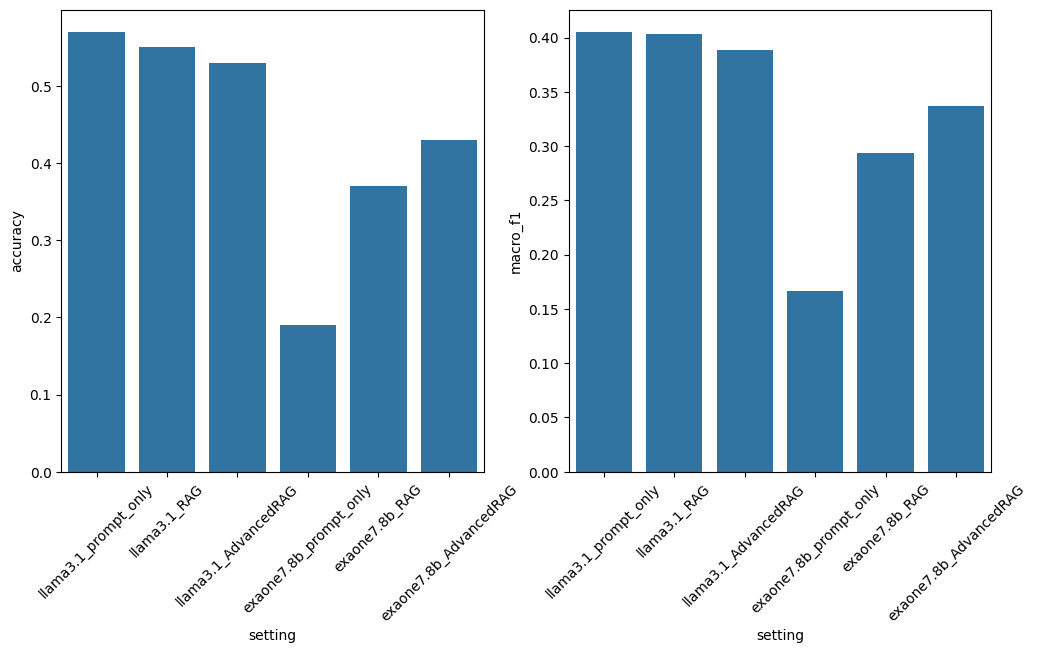

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(12, 6))

sns.barplot(data=all_df, x="setting", y="accuracy", ax=axes[0])
sns.barplot(data=all_df, x="setting", y="macro_f1", ax=axes[1])
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.show()

## 14. (선택) LoRA 결합

lama3.1용 PubMed LoRA 다운로드 + GGUF 변환 셀 추가

In [19]:

!pip -q install huggingface_hub

PUBMED_LORA_REPO = "anuragphukan5/PubMed-Llama-3.1-8B-Instruct"
LORA_DIR = "/content/pubmed_lora_llama31"

from huggingface_hub import snapshot_download
import os

if not os.path.exists(LORA_DIR) or len(os.listdir(LORA_DIR)) == 0:
    snapshot_download(repo_id=PUBMED_LORA_REPO, local_dir=LORA_DIR, local_dir_use_symlinks=False)
    print("✅ downloaded:", LORA_DIR)
else:
    print("✅ already exists:", LORA_DIR)

!ls -lh {LORA_DIR}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

✅ downloaded: /content/pubmed_lora_llama31
total 27M
-rw-r--r-- 1 root root  815 Feb 10 00:54 adapter_config.json
-rw-r--r-- 1 root root  27M Feb 10 00:54 adapter_model.safetensors
drwxr-xr-x 2 root root 4.0K Feb 10 00:54 checkpoint-939
-rw-r--r-- 1 root root 3.0K Feb 10 00:54 README.md
-rw-r--r-- 1 root root 5.2K Feb 10 00:54 training_args.bin


LoRA → GGUF 변환 (llama.cpp 스크립트 사용)

In [20]:
!ls pubmed_lora_llama31/

adapter_config.json	   checkpoint-939  training_args.bin
adapter_model.safetensors  README.md


In [21]:
import os, glob, re, shutil, subprocess, textwrap

LLAMA_CPP = "/content/llama.cpp"
CONVERTER = f"{LLAMA_CPP}/convert_lora_to_gguf.py"

# 네가 다운로드한 LoRA 폴더(스냅샷 받은 폴더)
LORA_BASE_DIR = "/content/pubmed_lora_llama31"

# 최종 출력 gguf 파일 경로
LORA_GGUF_OUT = "/content/pubmed_lora_llama31.gguf"

assert os.path.exists(LORA_BASE_DIR), f"LoRA 폴더가 없습니다: {LORA_BASE_DIR}"
assert os.path.exists(CONVERTER), f"변환 스크립트가 없습니다: {CONVERTER} (llama.cpp 경로 확인)"

def pick_latest_checkpoint_dir(base_dir: str) -> str:
    """
    base_dir 바로 아래에 checkpoint-* 폴더가 있으면 step이 가장 큰 것을 선택.
    없으면 base_dir 자체를 반환.
    """
    cks = [p for p in glob.glob(os.path.join(base_dir, "checkpoint-*")) if os.path.isdir(p)]
    if not cks:
        return base_dir

    def step(p):
        m = re.search(r"checkpoint-(\d+)", os.path.basename(p))
        return int(m.group(1)) if m else -1

    cks_sorted = sorted(cks, key=step)
    return cks_sorted[-1]

def ensure_adapter_filename(dir_path: str):
    """
    converter가 보통 기대하는 adapter_model.safetensors 형태로 맞춤.
    adapter_model.safetensor(단수)면 safetensors로 rename.
    """
    cand = glob.glob(os.path.join(dir_path, "adapter_model.safetensor"))  # 단수
    if cand:
        src = cand[0]
        dst = os.path.join(dir_path, "adapter_model.safetensors")
        if not os.path.exists(dst):
            print(f"🔧 rename: {src} -> {dst}")
            os.rename(src, dst)

    # 만약 adapter_model.safetensors가 없고, 다른 이름으로 있으면 알려줌
    if not os.path.exists(os.path.join(dir_path, "adapter_model.safetensors")):
        others = glob.glob(os.path.join(dir_path, "*.safetensor*"))
        print("⚠️ adapter_model.safetensors 를 못 찾았습니다.")
        print("   safetensor 후보:", [os.path.basename(x) for x in others])

def show_dir(dir_path: str):
    print("📁 Using LoRA dir:", dir_path)
    for f in sorted(os.listdir(dir_path)):
        p = os.path.join(dir_path, f)
        if os.path.isfile(p):
            print(f"  - {f} ({os.path.getsize(p)/1024/1024:.1f} MB)")
        else:
            print(f"  - {f}/")

# 1) checkpoint-* 있으면 최신을 우선 사용
LORA_DIR = pick_latest_checkpoint_dir(LORA_BASE_DIR)

# 2) 혹시 최신 체크포인트 안에 adapter가 없으면 base_dir도 한 번 더 시도
ensure_adapter_filename(LORA_DIR)
if not os.path.exists(os.path.join(LORA_DIR, "adapter_model.safetensors")):
    # base_dir에 adapter가 있을 수도 있어서 fallback
    ensure_adapter_filename(LORA_BASE_DIR)
    if os.path.exists(os.path.join(LORA_BASE_DIR, "adapter_model.safetensors")):
        LORA_DIR = LORA_BASE_DIR

show_dir(LORA_DIR)

# 3) 기존 gguf 있으면 삭제(강제 재생성)
if os.path.exists(LORA_GGUF_OUT):
    print("🧹 remove existing:", LORA_GGUF_OUT)
    os.remove(LORA_GGUF_OUT)

# 4) 변환 실행(강제)
cmd = ["python", CONVERTER, LORA_DIR, "--outfile", LORA_GGUF_OUT]
print("▶️", " ".join(cmd))
proc = subprocess.run(cmd, text=True, capture_output=True)
print(proc.stdout)
print(proc.stderr)

# 5) 결과 확인
if os.path.exists(LORA_GGUF_OUT) and os.path.getsize(LORA_GGUF_OUT) > 0:
    print("✅ LoRA GGUF created:", LORA_GGUF_OUT, f"({os.path.getsize(LORA_GGUF_OUT)/1024/1024:.1f} MB)")
else:
    raise RuntimeError("❌ GGUF 생성 실패. 위 stderr 로그를 확인하세요.")


📁 Using LoRA dir: /content/pubmed_lora_llama31/checkpoint-939
  - README.md (0.0 MB)
  - adapter_config.json (0.0 MB)
  - adapter_model.safetensors (26.0 MB)
  - optimizer.pt (52.2 MB)
  - rng_state.pth (0.0 MB)
  - scheduler.pt (0.0 MB)
  - trainer_state.json (0.0 MB)
  - training_args.bin (0.0 MB)
▶️ python /content/llama.cpp/convert_lora_to_gguf.py /content/pubmed_lora_llama31/checkpoint-939 --outfile /content/pubmed_lora_llama31.gguf

INFO:lora-to-gguf:Loading base model from Hugging Face: meta-llama/Llama-3.1-8B-Instruct
INFO:httpx:HTTP Request: HEAD https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct/resolve/main/config.json "HTTP/1.1 401 Unauthorized"
ERROR:lora-to-gguf:Failed to load base model config: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct.
401 Client Error. (Request ID: Root=1-698a81de-029adbb918dc42d675a867da;b3da68a4-446b-4e7a-9e03-d2dedd2c751f)

Cannot access gated repo for url ht

RuntimeError: ❌ GGUF 생성 실패. 위 stderr 로그를 확인하세요.

In [ ]:
LLAMA_CPP = "/content/llama.cpp"
LORA_GGUF = "/content/pubmed_lora_llama31"

# convert_lora_to_gguf.py는 llama.cpp에 포함
if not os.path.exists(LORA_GGUF):
    !python {LLAMA_CPP}/convert_lora_to_gguf.py {LORA_DIR} --outfile {LORA_GGUF}
else:
    print("✅ already exists:", LORA_GGUF)

!ls -lh {LORA_GGUF}


llama-server 실행 함수에 --lora 옵션 지원 추가

In [ ]:
def start_llama_server(model_path: str, port: int, ctx_size=2048, lora_path: str | None = None):
    cmd = [
        LLAMA_SERVER_BIN,
        "-m", model_path,
        "--host", "127.0.0.1",
        "--port", str(port),
        "--ctx-size", str(ctx_size),
    ]
    if lora_path is not None:
        cmd += ["--lora", lora_path]   # ✅ LoRA 결합

    print("Starting server:", " ".join(cmd))
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    if not wait_server_ready(port, timeout=180):
        err_tail = ""
        try:
            err_tail = (p.stderr.read() or "")[-4000:]
        except Exception:
            pass
        p.terminate()
        raise RuntimeError(f"Server not ready on port {port}. STDERR tail:\n{err_tail}")
    return p


Llama3.1 + PubMedLoRA로 3종(prompt/RAG/AdvRAG) 벤치 추가

In [ ]:
LORA_DIR  = "/content/pubmed_lora_llama31"
LORA_GGUF = "/content/pubmed_lora_llama31.gguf"

!python /content/llama.cpp/convert_lora_to_gguf.py {LORA_DIR} --outfile {LORA_GGUF}
!ls -lh {LORA_GGUF}


In [ ]:
# ============================================================
# Llama3.1 + PubMed LoRA (Prompt / RAG / Advanced RAG)
# ============================================================

PORT_LLAMA_LORA = 18083  # 포트 충돌 방지 (원하면 자동포트탐색 사용)

p = None
try:
    p = start_llama_server(LLAMA_MODEL_PATH, PORT_LLAMA_LORA, ctx_size=2048, lora_path=LORA_GGUF)

    results.append(run_pubmedqa_http(
        "llama3.1+pubmedLoRA_prompt_only", PORT_LLAMA_LORA,
        lambda it: prompt_only(it["question"]), items))

    results.append(run_pubmedqa_http(
        "llama3.1+pubmedLoRA_RAG", PORT_LLAMA_LORA,
        lambda it: prompt_rag(it["question"], retrieve_topk(it["question"], k=TOPK)), items))

    results.append(run_pubmedqa_http(
        "llama3.1+pubmedLoRA_AdvancedRAG", PORT_LLAMA_LORA,
        lambda it: prompt_rag(it["question"], retrieve_rerank(it["question"], topn=ADV_TOPN, topk=TOPK)), items))

finally:
    stop_server(p)
    print("Llama+LoRA server stopped")

all_df = pd.DataFrame(results)
all_df


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(1,2, figsize=(12, 6))

sns.barplot(data=all_df, x="setting", y="accuracy", ax=axes[0])
sns.barplot(data=all_df, x="setting", y="macro_f1", ax=axes[1])
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

Bio-SBERT 임베더/인덱스 추가 (기존 RAG 인덱스 셀 옆에 추가)

In [ ]:
import numpy as np, faiss
from sentence_transformers import SentenceTransformer

# 1) 문서 코퍼스(동일)
docs = [it["context"] for it in eval_items]

# 2) Bio-SBERT 후보들 (토큰 없이 공개인 경우가 대부분)
# - 옵션 A: 범용 Bio Sentence Embedding로 자주 쓰는 모델
BIO_SBERT_ID = "pritamdeka/S-BioBERT-snli-mnli"     # 안되면 아래로 교체
# BIO_SBERT_ID = "sentence-transformers/all-mpnet-base-v2"  # fallback(일반)
# BIO_SBERT_ID = "allenai/specter2_base"            # (논문 임베딩 계열, 환경 따라 다를 수 있음)

bio_embed = SentenceTransformer(BIO_SBERT_ID)

# 3) Bio-SBERT 문서 임베딩 + FAISS(IP=cosine with normalized)
bio_doc_emb = bio_embed.encode(docs, normalize_embeddings=True, show_progress_bar=True)
bio_doc_emb = np.asarray(bio_doc_emb, dtype=np.float32)

bio_index = faiss.IndexFlatIP(bio_doc_emb.shape[1])
bio_index.add(bio_doc_emb)

def retrieve_topk_biosbert(query: str, k=5):
    q_emb = bio_embed.encode([query], normalize_embeddings=True)
    D, I = bio_index.search(np.asarray(q_emb, dtype=np.float32), k)
    return [docs[i] for i in I[0]]


Bio-SBERT + Advanced RAG(리랭커) 추가

In [ ]:
from sentence_transformers import CrossEncoder

# 기존 reranker 유지 or 도메인 리랭커로 교체 가능
RERANKER_ID = "cross-encoder/ms-marco-MiniLM-L-6-v2"
bio_reranker = CrossEncoder(RERANKER_ID)

def retrieve_rerank_biosbert(query: str, topn=50, topk=5):
    cand = retrieve_topk_biosbert(query, k=topn)
    pairs = [(query, c) for c in cand]
    scores = bio_reranker.predict(pairs)
    ranked = [c for _, c in sorted(zip(scores, cand), key=lambda x: x[0], reverse=True)]
    return ranked[:topk]


“Bio-SBERT RAG/AdvRAG”를 Llama3.1에 추가 (results.append 확장)

In [ ]:
# Llama 3.1 + Bio-SBERT RAG
results.append(run_pubmedqa_http(
    "llama3.1_BioSBERT_RAG", PORT_LLAMA,
    lambda it: prompt_rag(it["question"], retrieve_topk_biosbert(it["question"], k=TOPK)), items))

results.append(run_pubmedqa_http(
    "llama3.1_BioSBERT_AdvancedRAG", PORT_LLAMA,
    lambda it: prompt_rag(it["question"], retrieve_rerank_biosbert(it["question"], topn=ADV_TOPN, topk=TOPK)), items))


EXAONE에도 동일하게 추가

In [ ]:
results.append(run_pubmedqa_http(
    "exaone7.8b_BioSBERT_RAG", PORT_EXAONE,
    lambda it: prompt_rag(it["question"], retrieve_topk_biosbert(it["question"], k=TOPK)), items))

results.append(run_pubmedqa_http(
    "exaone7.8b_BioSBERT_AdvancedRAG", PORT_EXAONE,
    lambda it: prompt_rag(it["question"], retrieve_rerank_biosbert(it["question"], topn=ADV_TOPN, topk=TOPK)), items))


“리트리버 품질” 분석(선택이지만 강추)

In [ ]:
import numpy as np

def self_retrieval_hit_rate(retrieve_fn, k=5):
    hit = 0
    for it in eval_items:
        q = it["question"]
        gold_ctx = it["context"]
        got = retrieve_fn(q, k=k)
        # 단순 포함 체크(거친 sanity)
        if any(gold_ctx[:200] in g for g in got):
            hit += 1
    return hit / len(eval_items)

print("MiniLM self-hit@5 (baseline):", self_retrieval_hit_rate(retrieve_topk, k=5))
print("BioSBERT self-hit@5:", self_retrieval_hit_rate(retrieve_topk_biosbert, k=5))
